In [1]:
from imag import *

In [2]:
# @title Test code space
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from copy import deepcopy
from networkx.algorithms.approximation import max_clique

## Ising model test

In [37]:
# @title Ising model Periodic
n = 4

coeffs_Z = -0.5*np.ones(3)
coeffs_X = -0.1*np.ones(4)
coeffs = np.concatenate([coeffs_Z, coeffs_X])

print(coeffs)
ops = [
    qml.PauliZ(0) @ qml.PauliZ(1),
    qml.PauliZ(1) @ qml.PauliZ(2),
    qml.PauliZ(2) @ qml.PauliZ(3),
    #qml.PauliZ(0) @ qml.PauliZ(3), # periodic boundary condition
    qml.PauliX(0),
    qml.PauliX(1),
    qml.PauliX(2),
    qml.PauliX(3)
    ]

H_ising = qml.Hamiltonian(coeffs, ops)
H_ising = np.matrix(qml.matrix(H_ising))
#print(H_ising)
#H = #np.array(...) 2D matrix
hamiltonian = Hamiltonian(H_ising, commute_map=True)

[-0.5 -0.5 -0.5 -0.1 -0.1 -0.1 -0.1]


In [38]:
# Get exact eigen-value and vector pairs

In [39]:
evals, evectors = np.linalg.eig(H_ising)

In [68]:
evales = evals.real
evales.sort()
evales

array([-1.5308674 , -1.52933139, -0.65375097, -0.65221496, -0.50153601,
       -0.5       , -0.37711643, -0.37558042,  0.37558042,  0.37711643,
        0.5       ,  0.50153601,  0.65221496,  0.65375097,  1.52933139,
        1.5308674 ])

In [41]:
evectors.shape

(16, 16)

In [100]:
# @title Ising model
n = 4

#coeffs_Z = -0.5*np.ones(3)
coeffs_X = -0.1*np.ones(4)
coeffs = np.concatenate([coeffs_Z, coeffs_X])
coeffs = coeffs_X
#print(coeffs)
ops = [
    #qml.PauliZ(0) @ qml.PauliZ(1),
    #qml.PauliZ(1) @ qml.PauliZ(2),
    #qml.PauliZ(2) @ qml.PauliZ(3),
    #qml.PauliZ(0) @ qml.PauliZ(3), # periodic boundary condition
    qml.PauliX(0),
    qml.PauliX(1),
    qml.PauliX(2),
    qml.PauliX(3)
    ]

H_ising = qml.Hamiltonian(coeffs, ops)
H_ising = np.matrix(qml.matrix(H_ising))
#print(H_ising)
#H = #np.array(...) 2D matrix
hamiltonian = Hamiltonian(H_ising, commute_map=True)

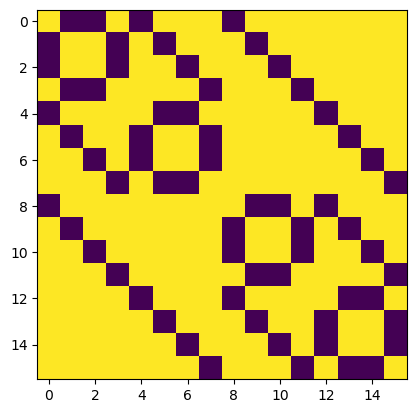

In [101]:
plt.imshow(H_ising.real)

In [102]:
G_b = get_binary_graph(hamiltonian) # get commuting graph
g_classic = deepcopy(G_b)
max_cliques = []
while len(g_classic.nodes) >0:
    clique = max_clique(g_classic)
    max_cliques.append(clique)
    for node in clique:
        g_classic.remove_node(node)
print(max_cliques)

[{'IXII', 'IIXI', 'IIIX', 'XIII'}]


In [103]:
N = hamiltonian.qubit_num # number of qubits
dev = qml.device('default.qubit', wires=N+1, shots=2000)

In [104]:
hamiltonian.local_decomposition["Pstring"]


0    IIIX
1    IIXI
2    IXII
3    XIII
Name: Pstring, dtype: object

In [105]:
#@qml.defer_measurements
@qml.qnode(dev)
def evolve_hamiltonian(h:Hamiltonian, max_cliques:list, t:float, iter:int, N:int, get_state= False):
    for i in range(N-1):
        qml.Hadamard(i)
    print(f"Evolve time:{t*iter}")
    print(f"Trotter-Level:{iter}")
    print(f"Wires:{N}")
    if np.fabs(t)<1E-8:
        hermit = qml.Hermitian(h.Hamiltonian, wires=range(h.qubit_num))
        return qml.expval(hermit)

    qml.Barrier(wires=range(N))
    # coef 
    gamma = coef_scale = np.abs(h.local_decomposition.iloc[:, 4]).max()
     
    for k in range(iter):
        #print(f"{k+1}/{iter}", end="\t")
        i=0
        l = len(max_cliques)
        for i, c in enumerate(max_cliques):
            for j, p in enumerate(c):
                coef_i = complex(h.local_decomposition.loc[h.local_decomposition["Pstring"] == p].iloc[0, 3])
                #print(coef)
                evolve_circuit(
                    p,
                    0,
                    coef_i,
                    t,
                    True, #imaginary,
                    gamma
                )
                qml.Barrier(wires=range(h.qubit_num))
                i+=1
                # mid-measurement
                m0 = qml.measure(N-1, postselect=0)#-requires new wires for each mid-measurement.
                #print(m0)
                #qml.cond((m0 == 1), qml.Hadamard)(N+1)
                #m1 = (qml.measure(N +1))
                #qml.cond(m0 == 1 and m1 == 0, qml.PauliX)(N+1)
                #if m0 == 1:
                #    print("Failed")
                #    break
                #
            #if m0==1:
            #    break
    if get_state:
        return qml.state()
    else:
        hermit = qml.Hermitian(h.Hamiltonian, wires=range(h.qubit_num))
        return qml.expval(hermit)

Evolve time:0.1
Trotter-Level:1
Wires:5


/var/folders/wv/cwvgxcp14lxcs5jn0r6p87sr0000gn/T/ipykernel_11321/1822880935.py:3: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


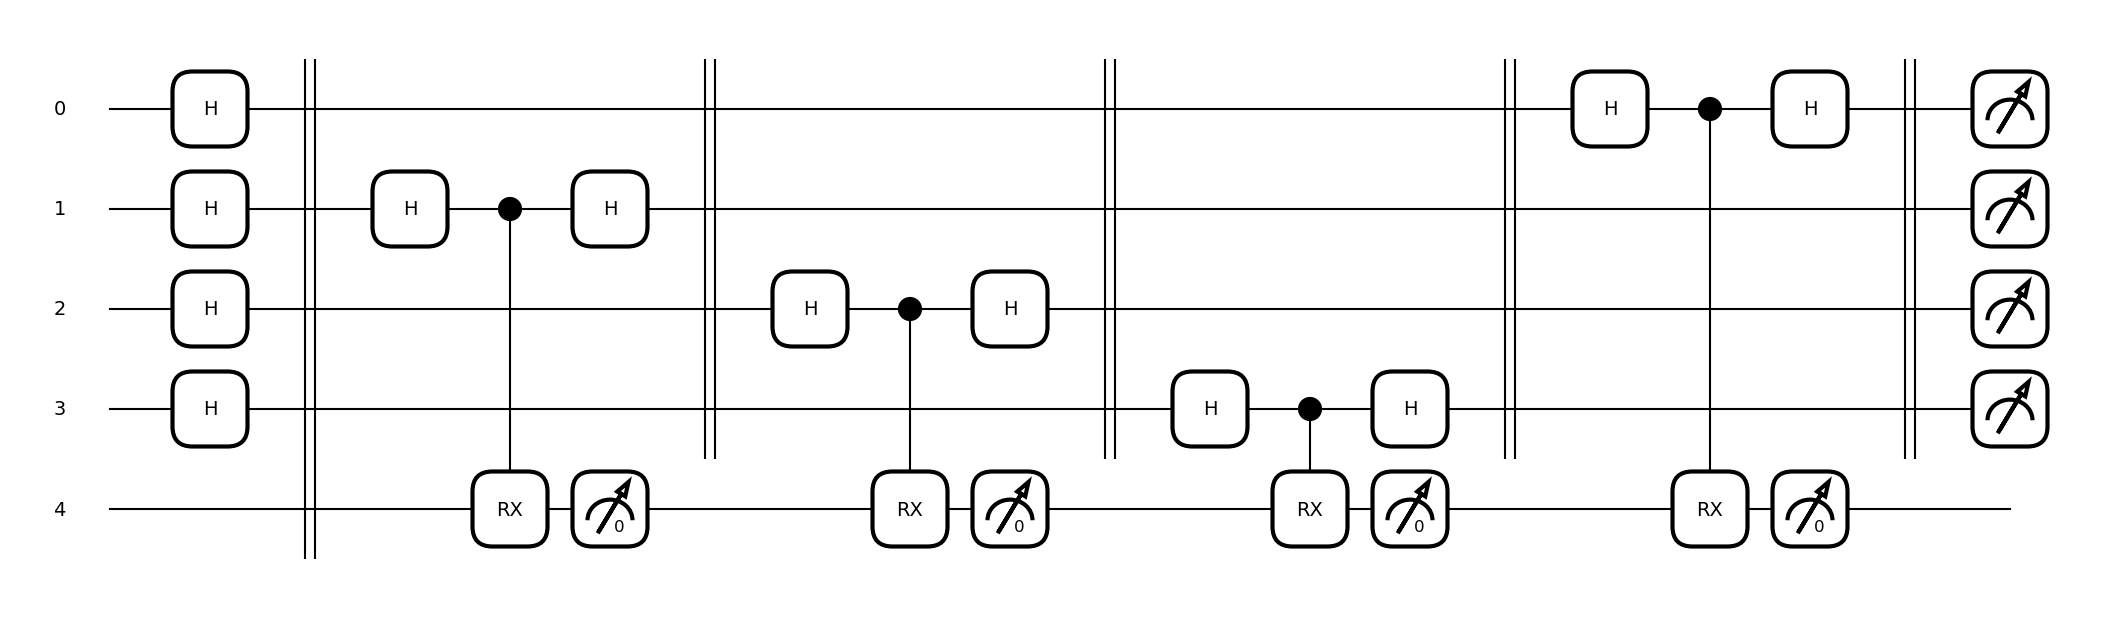

In [106]:
t=0.1
fig, ax = qml.draw_mpl(evolve_hamiltonian)(hamiltonian, max_cliques, t, 1,N+1)
fig.show()

## Ground state test

If the given state is a ground state, then the routine must act as Identity gate.

$$H = \sum_i X^i$$

In [107]:
evolve_hamiltonian(hamiltonian, max_cliques, 0.1, 2, N+1) # t = 0.2, (sec)

Evolve time:0.2
Trotter-Level:2
Wires:5


-0.39999999999998587

In [108]:
trotter_step = 10
energies = []
dt = 0.1
print(dt)
for i in range(0, 4):
    print(f"Configuration:t={dt}, T_level:{trotter_step}")
    e = evolve_hamiltonian(hamiltonian, max_cliques, dt, i*trotter_step, N+1) #
    print(f"E:{e}")
    energies.append(e)

0.1
Configuration:t=0.1, T_level:10
Evolve time:0.0
Trotter-Level:0
Wires:5
E:-0.4000000000000003
Configuration:t=0.1, T_level:10
Evolve time:1.0
Trotter-Level:10
Wires:5
E:-0.39999999999998587
Configuration:t=0.1, T_level:10
Evolve time:2.0
Trotter-Level:20
Wires:5
E:-0.39999999999998587
Configuration:t=0.1, T_level:10
Evolve time:3.0
Trotter-Level:30
Wires:5
E:-0.39999999999998587


In [78]:
i = 3
evolve_hamiltonian(hamiltonian, max_cliques, dt, i*trotter_step, N+1) #

Evolve time:3.0
Trotter-Level:30
Wires:5


-1.5308674019768724

-1.530867401976872
-1.5293313870342808
-0.6537509705501752
-0.652214955607584
-0.5015360149425906
-0.5000000000000002
-0.37711643142669704
-0.37558041648410556
0.37558041648410667
0.37711643142669754
0.49999999999999983
0.5015360149425908
0.6522149556075842
0.6537509705501754
1.529331387034283
1.5308674019768669


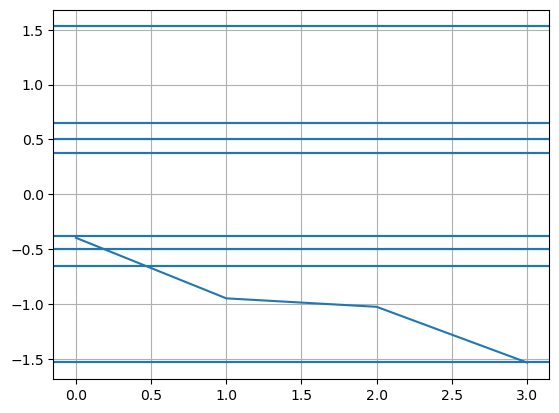

In [99]:
plt.plot(range(0, 4), energies)
for e in evales:
    print(e)
    plt.axhline(e)
plt.grid()

In [69]:
evales = evals.real
evales.sort()
evales

array([-1.5308674 , -1.52933139, -0.65375097, -0.65221496, -0.50153601,
       -0.5       , -0.37711643, -0.37558042,  0.37558042,  0.37711643,
        0.5       ,  0.50153601,  0.65221496,  0.65375097,  1.52933139,
        1.5308674 ])

In [83]:
N = hamiltonian.qubit_num # number of qubits
dev2 = qml.device('default.qubit', wires=N+1, shots=None)

In [95]:
#@qml.defer_measurements
@qml.qnode(dev2)
def evolve_hamiltonian2(h:Hamiltonian, max_cliques:list, t:float, iter:int, N:int, get_state= False):
    for i in range(N-1):
        qml.Hadamard(i)
    print(f"Evolve time:{t*iter}")
    print(f"Trotter-Level:{iter}")
    print(f"Wires:{N}")
    if np.fabs(t)<1E-8:
        hermit = qml.Hermitian(h.Hamiltonian, wires=range(h.qubit_num))
        return qml.expval(hermit)

    qml.Barrier(wires=range(N))
    # coef 
    gamma = coef_scale = np.abs(h.local_decomposition.iloc[:, 4]).max()
     
    for k in range(iter):
        #print(f"{k+1}/{iter}", end="\t")
        i=0
        l = len(max_cliques)
        for i, c in enumerate(max_cliques):
            for j, p in enumerate(c):
                coef_i = complex(h.local_decomposition.loc[h.local_decomposition["Pstring"] == p].iloc[0, 3])
                #print(coef)
                evolve_circuit(
                    p,
                    0,
                    coef_i,
                    t,
                    True, #imaginary,
                    gamma
                )
                qml.Barrier(wires=range(h.qubit_num))
                i+=1
                # mid-measurement
                m0 = qml.measure(N-1, postselect=0)#-requires new wires for each mid-measurement.
                #print(m0)
                #qml.cond((m0 == 1), qml.Hadamard)(N+1)
                #m1 = (qml.measure(N +1))
                #qml.cond(m0 == 1 and m1 == 0, qml.PauliX)(N+1)
                #if m0 == 1:
                #    print("Failed")
                #    break
                #
            #if m0==1:
            #    break
    if get_state:
        return qml.state()
    else:
        hermit = qml.Hermitian(h.Hamiltonian, wires=range(h.qubit_num))
        return qml.expval(hermit)

In [96]:
i = 3
state = evolve_hamiltonian2(hamiltonian, max_cliques, dt, i*trotter_step, N+1, get_state=True) #

state

Evolve time:3.0
Trotter-Level:30
Wires:5


ValueError: Cannot use StateMP as a measurement when using qml.defer_measurements. Deferred measurements can occur automatically when using mid-circuit measurements on a device that does not support them.